# Relative contributions of the prior and likelihood scores

In [1]:
import numpy as np
import os, sys

# project_root = os.getcwd()
project_root = os.path.abspath("")  # alternative
base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import zarr

from utils import remove_all_ticks_and_labels

first, how does the prior model change with the phase of the oscillation?

model loaded!


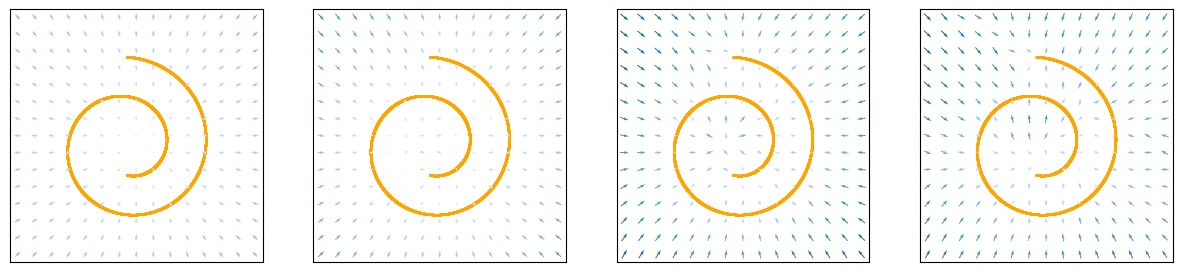

In [12]:
from dataset_utils import generate_2d_swiss_roll
num_samples_in_gt_manifold = 5e3
dataset = generate_2d_swiss_roll(num_samples_in_gt_manifold, True)[1]

# ----------------- calculate flow field for diffusion model ----------------- #
from utils import select_model
prior_sampler = select_model('unconditional-dendritic', 47)[0]

lim=1.5
lims=[-lim-.1, lim+.1]
num_vectors_per_dim=15
from likelihood_utils import calculate_prior_score_flow_field
temps = [1, 0.5, 0.25, 0]
scores = []
colors = []
for t in temps:
    score_xs, score_ys, color = calculate_prior_score_flow_field(prior_sampler, lim, num_vectors_per_dim, t)
    scores.append((score_xs, score_ys))
    colors.append(color)
    
# ----------------------------------- plot ----------------------------------- #
fig, axes = plt.subplots(1, 4, figsize=(15, 7))
for i, t in enumerate(temps):
    ax = axes[i]
    ax.scatter(*dataset[:, :2].T, s=1, alpha=0.8, c='orange')
    q = ax.quiver(np.linspace(-lim, lim, num_vectors_per_dim), np.linspace(-lim, lim, num_vectors_per_dim), 
            scores[i][0], scores[i][1], 
            colors[i],
            cmap='Blues',
            angles='xy', scale_units='xy', pivot='mid',
            scale=14,
            clim=(0, 4))
    ax.set_aspect('equal')
    ax.set(xlim=lims, ylim=lims, aspect='equal')
    remove_all_ticks_and_labels(ax)

how does the likelihood model change?

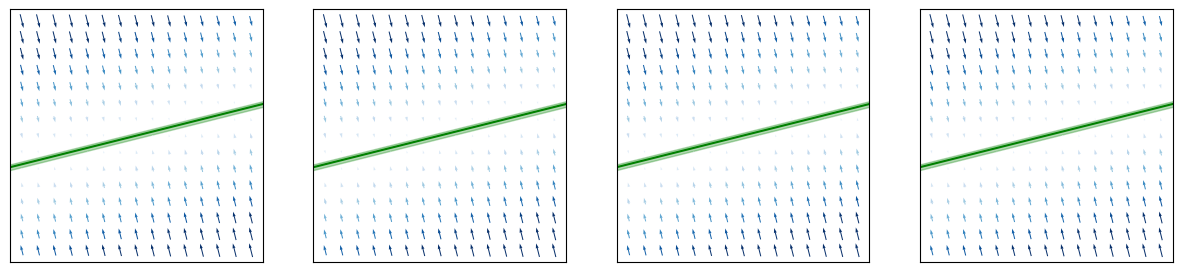

In [13]:
# --------------- calculate flow field for the likelihood model -------------- #
from likelihood_utils import compute_occlusion_score_flow_field
from plot import draw_constraint_line

v = np.array([[4, 1]]).T  # constraint vector
M = v / np.linalg.norm(v)
Mm = M @ M.T
Mm = torch.from_numpy(Mm).float()
constraint_sigma = 0.035

x_hyps, scores, color_bu = compute_occlusion_score_flow_field(Mm, num_vectors_per_dim=15)

fig, axes = plt.subplots(1, 4, figsize=(15, 7))
for i, t in enumerate(temps):
    ax = axes[i]
    draw_constraint_line(ax, v, constraint_sigma)
    ax.quiver(*x_hyps.T, *scores.T,
                color_bu,
                cmap="Blues",
                angles = 'xy',
                scale_units = 'width',
                scale = 25,
                pivot = 'mid',
                clim=(-.05, 1.4)
                )
    ax.set(xlim=lims, ylim=lims, aspect='equal')
    remove_all_ticks_and_labels(ax)

and now the joint posterior...

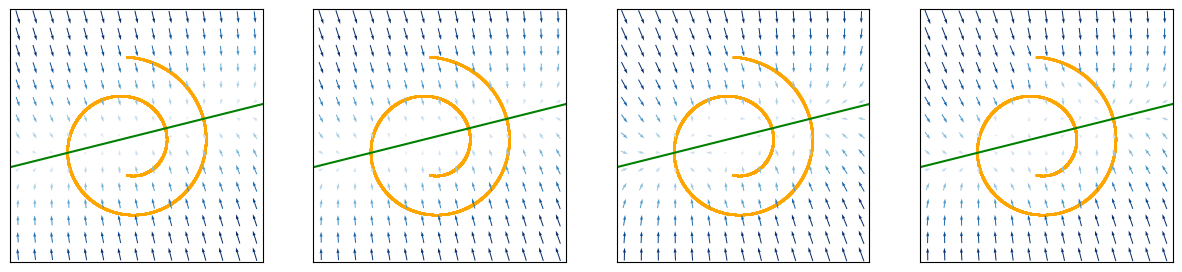

In [14]:
from likelihood_utils import calculate_posterior_score_flow_field_bu

s_bu = 0.015
scores = calculate_posterior_score_flow_field_bu(temps, lim, num_vectors_per_dim, prior_sampler, Mm, constraint_sigma, s_bu)

fig, axes = plt.subplots(1, 4, figsize=(15, 7))
for i, t in enumerate(temps):
    ax = axes[i]
    score_xs, score_ys, color = scores[i]
    ax.scatter(*dataset[:, :2].T, s=1, alpha=0.8, c='orange')
    draw_constraint_line(ax, v, constraint_sigma, show_stdev=False)
    q = ax.quiver(np.linspace(-lim, lim, num_vectors_per_dim), np.linspace(-lim, lim, num_vectors_per_dim), 
            score_xs, score_ys,
            color,
            cmap='Blues',
            angles='xy', scale_units='xy', pivot='mid',
            scale=20,
            clim=(0, 10))
    ax.set_aspect('equal')
    ax.set(xlim=lims, ylim=lims, aspect='equal')
    remove_all_ticks_and_labels(ax)

We want to quantify the relative contributions of the prior and likelihood flow fields. We can do this by computing the KL divergence between the (amortized) posterior distribution and the prior or likelihood distributions. 

We first generate many sequential samples from the prior and posterior distributions, and discretize the ambient space into a 20x20 grid to construct a histogram of samples which represents the probability that the sample will be sampled from a particular region of the ambient space. The KL divergence between this discrete probability distribution and the prior/likelihood distributions tells us their similarity. 

For convenience, we load samples that we have already generated. 

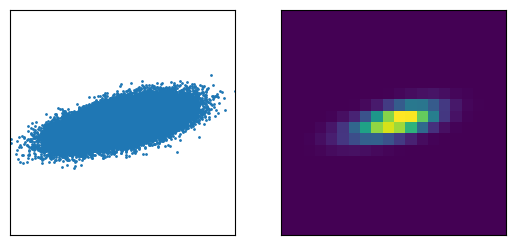

In [15]:
data_dir_kl = os.path.join(base_dir, 'core/saved_arrays/kl_divergence')
reverse_samples = zarr.load(os.path.join(data_dir_kl, 'reverse_samples_posterior_1e5.zarr'))

# turn the samples into a histogram
num_bins = 20
theta = 0  # temperature index / beta index

lim=3
bins = np.linspace(-lim, lim, num_bins+1)
z_rf_hist = np.histogram2d(reverse_samples[:, theta, 0], reverse_samples[:, theta, 1], bins=bins)[0]

# plot
fig, ax = plt.subplots(1, 2)
ax[0].scatter(*reverse_samples[:, theta].T, s=1)
ax[0].set(xlim=[-lim, lim], ylim=[-lim, lim])
ax[0].set_aspect('equal')
ax[1].imshow(z_rf_hist.T, origin='lower')

for a in ax:
    remove_all_ticks_and_labels(a)



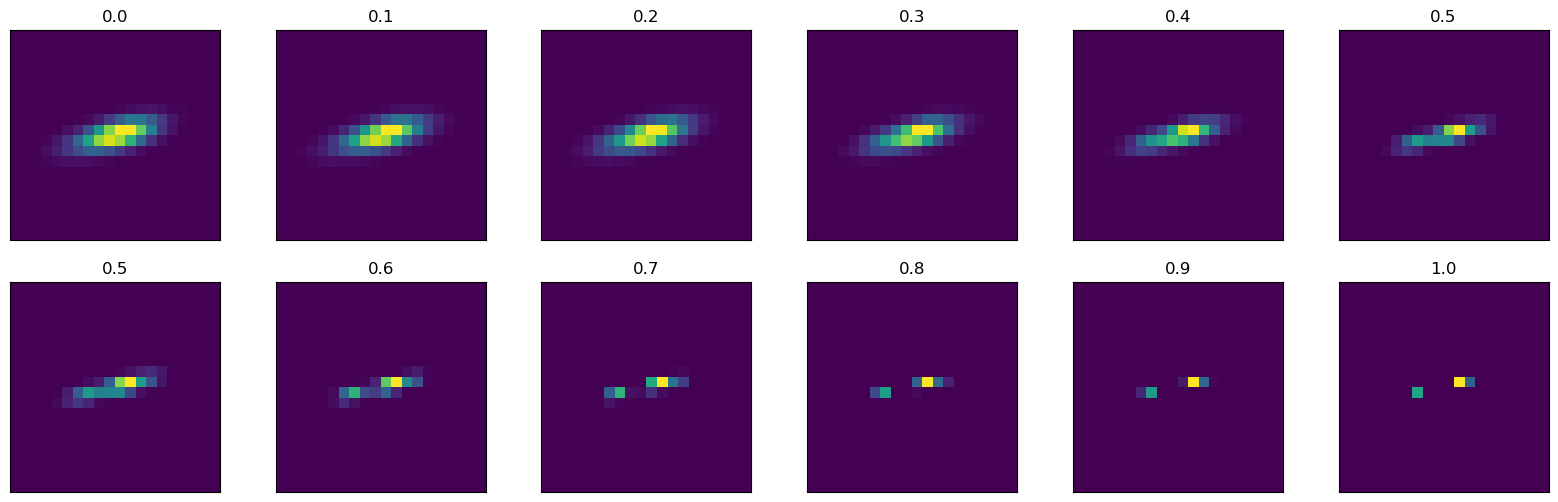

In [16]:
# now calculate the histogram of samples from the amortized posterior for all thetas
from likelihood_utils import calculate_histogram_for_seq_data

histograms = calculate_histogram_for_seq_data(reverse_samples, num_bins=20, lim=3)

# plot the histograms of the posterior distributions as a function of beta (0 to 1)
fig, ax = plt.subplots(2, 6, figsize=(20, 6))
idx0 = 0
idx1 = 0
for h, hist in enumerate(histograms):
    if h in [0, 10, 20, 30, 40, 50]:
        a = ax[0, idx0]
        a.set_aspect('equal')
        a.set(title=f'{h/100}')
        a.imshow(hist.T, origin='lower')
        remove_all_ticks_and_labels(a)
        idx0 += 1
    if h in [50, 60, 70, 80, 90, 100]:
        a = ax[1, idx1]
        a.set_aspect('equal')
        a.set(title=f'{h/100}')
        a.imshow(hist.T, origin='lower')
        remove_all_ticks_and_labels(a)
        idx1 += 1

now let's build a histogram of points sampled from the prior and likelihood distributions

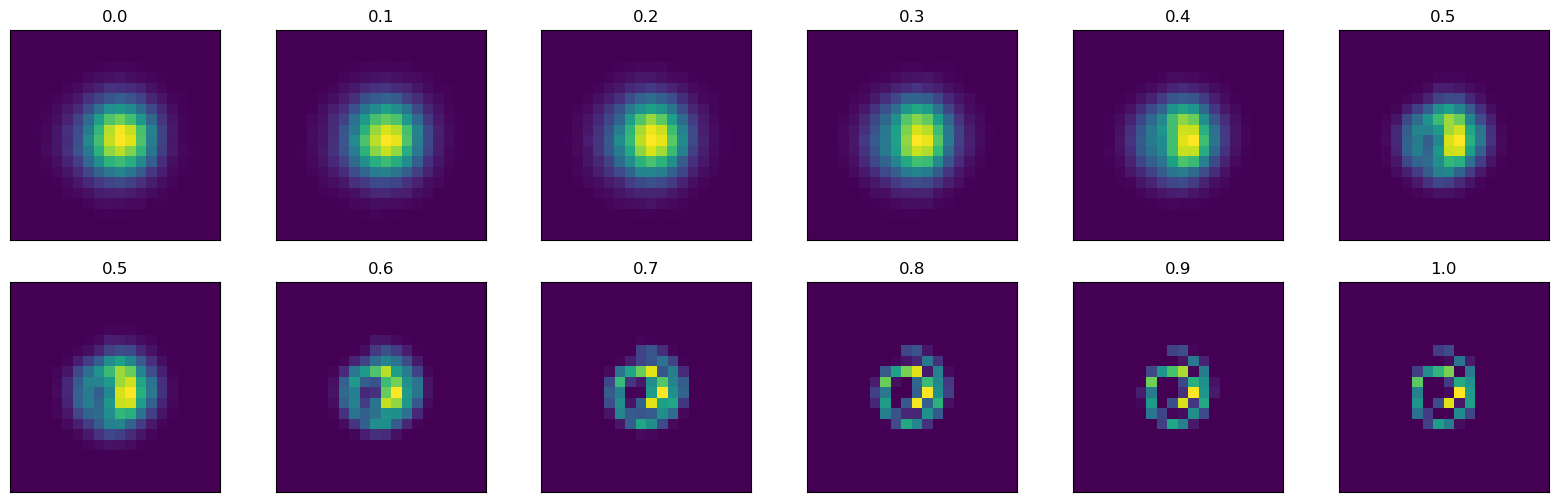

In [17]:
# load the prior samples
prior_rev_samples = zarr.load(os.path.join(data_dir_kl, 'prior_rev_samples_1e5.zarr'))

# now calculate and plot the histograms of the prior samples for all thetas
from likelihood_utils import calculate_histogram_for_seq_data

prior_histograms = calculate_histogram_for_seq_data(prior_rev_samples, num_bins=20, lim=3)

# plot 
fig, ax = plt.subplots(2, 6, figsize=(20, 6))
idx0 = 0
idx1 = 0
for h, hist in enumerate(prior_histograms):
    if h in [0, 10, 20, 30, 40, 50]:
        a = ax[0, idx0]
        a.set_aspect('equal')
        a.set(title=f'{h/100}')
        a.imshow(hist.T, origin='lower')
        remove_all_ticks_and_labels(a)
        idx0 += 1
    if h in [50, 60, 70, 80, 90, 100]:
        a = ax[1, idx1]
        a.set_aspect('equal')
        a.set(title=f'{h/100}')
        a.imshow(hist.T, origin='lower')
        remove_all_ticks_and_labels(a)
        idx1 += 1

now calculate the kl divergence between the amortized posterior p and the prior q for all values of beta

In [18]:
from scipy.stats import entropy

# can't compute KL divergence when bins are empty, so a (biased) solution is to a small epsilon to each bin
epsilon = 1e-5  

p = histograms[1] + epsilon  # posterior distribution
p = p.flatten() / np.sum(p)  # turn into a vector and then normalize

In [19]:
# ---------- divergence between amortized posterior and likelihood ---------- #
q_llh = histograms[0] + epsilon  # dist to compare to
q_llh = q_llh.flatten() / np.sum(q_llh)

entropies_llh = []
for phi in range(len(histograms)):
    p = histograms[phi] + epsilon  # test dist
    p = p.flatten() / np.sum(p)  # turn into a vector and then normalize
    entropies_llh.append(entropy(p, q_llh))    
entropies_llh = np.stack(entropies_llh)


# ---------- divergence between the amortized posterior to the prior --------- #
q_prior = prior_histograms[100] + epsilon  # dist to compare to
q_prior = q_prior.flatten() / np.sum(q_prior)

entropies_prior = []
for phi in range(len(prior_histograms)):
    p = histograms[phi] + epsilon  # test dist
    p = p.flatten() / np.sum(p)  # turn into a vector and then normalize
    entropies_prior.append(entropy(p, q_prior))
entropies_prior = np.stack(entropies_prior)

plot the KL divergences as a function of oscillation phase

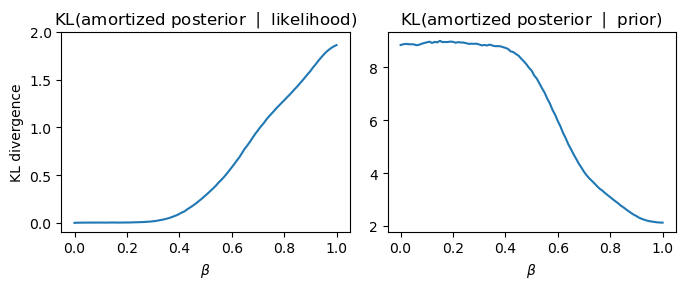

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[0].plot(np.linspace(0, 1, len(entropies_llh)), entropies_llh)
ax[0].set(title='KL(amortized posterior $\mid$ likelihood)', ylabel='KL divergence', xlabel='$\\beta$')
ax[0].set(yticks=[0, 0.5, 1, 1.5, 2])

ax[1].set(title='KL(amortized posterior $\mid$ prior)', xlabel='$\\beta$')
ax[1].plot(np.linspace(0, 1, len(entropies_prior)), entropies_prior)
fig.tight_layout()